In [15]:
import contextily as cx
import overpy
import geopandas as gpd
import qwikidata

In [2]:
def to_feature(elem):
    if elem.__class__ is overpy.Node:
        return {
            "geometry": {
                "type": "Point",
                "coordinates": [elem.lon, elem.lat]
            },
            "id": elem.id,
            "properties": elem.tags
        }
    else:
        return {
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[d.lon, d.lat] for d in elem.get_nodes()]]
            },
            "id": elem.id,
            "properties": elem.tags
        }

whole of GB == area["ISO3166-1"="GB"][admin_level=2];

In [3]:
api = overpy.Overpass()

In [4]:
county = 'East Sussex'

In [5]:
r_ways = api.query("""
[out:json];
area["name"="{}"][admin_level=6];
(
  way(area)["recycling_type"="centre"]["owner"];
  >;
);
out body;
""".format(county))

In [6]:
way_features = [to_feature(elem) for elem in r_ways.ways]
way_features

[{'geometry': {'type': 'Polygon',
   'coordinates': [[[Decimal('0.1821097'), Decimal('51.0437368')],
     [Decimal('0.1823387'), Decimal('51.0438088')],
     [Decimal('0.1822661'), Decimal('51.0439154')],
     [Decimal('0.1823938'), Decimal('51.0440178')],
     [Decimal('0.1820943'), Decimal('51.0442849')],
     [Decimal('0.1817355'), Decimal('51.0441313')],
     [Decimal('0.1821097'), Decimal('51.0437368')]]]},
  'id': 190799552,
  'properties': {'addr:city': 'Crowborough',
   'addr:housename': 'Wealden Industrial Estate',
   'addr:postcode': 'TN6 2JR',
   'addr:street': 'Farningham Road',
   'amenity': 'recycling',
   'name': 'Crowborough Recycling Centre',
   'owner': 'East Sussex County Council',
   'ownership': 'municipal',
   'recycling_type': 'centre',
   'website': 'https://new.eastsussex.gov.uk/rubbish-recycling/household-waste-recycling-sites/escc-crowboroughhwrs',
   'wikidata': 'Q106093676'}},
 {'geometry': {'type': 'Polygon',
   'coordinates': [[[Decimal('0.2974747'), Deci

In [16]:
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api

Q_HWRC = "Q106093676"
q42_dict = get_entity_dict_from_api(Q_HWRC)
q42 = WikidataItem(q42_dict)
q42

WikidataItem(label=Crowborough Recycling Centre, id=Q106093676, description=household waste recycling centre, aliases=[], enwiki_title=)

In [7]:
r_nodes = api.query("""
[out:json];
area["name"="{}"][admin_level=6];
(
  node(area)["recycling_type"="centre"]["owner"];
);
out body;
""".format(county))

In [8]:
node_features = [to_feature(elem) for elem in r_nodes.nodes]
node_features

[]

In [9]:
features = way_features + node_features

In [10]:
gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")
gdf

,geometry,addr:city,addr:housename,addr:postcode,addr:street,amenity,name,owner,ownership,recycling_type,...,recycling:furniture,recycling:mobile_phones,recycling:paint,recycling:printer_cartridges,recycling:rubble,recycling:tv_monitor,recycling:tyres,recycling:wood,addr:place,addr:unit
0,"POLYGON ((0.18211 51.04374, 0.18234 51.04381, ...",Crowborough,Wealden Industrial Estate,TN6 2JR,Farningham Road,recycling,Crowborough Recycling Centre,East Sussex County Council,municipal,centre,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((0.29747 50.78255, 0.29683 50.78223, ...",Eastbourne,NaN,BN22 8NB,St. Philip's Avenue,recycling,Eastbourne household waste recycling site,East Sussex County Council,municipal,centre,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((0.05541 50.79739, 0.05542 50.79737, ...",Newhaven,NaN,BN9 0EH,New Road,recycling,Newhaven Recycling Centre,East Sussex County Council,municipal,centre,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((0.07618 50.99401, 0.07582 50.99433, ...",Maresfield,NaN,TN22 2HN,Batts Bridge Road,recycling,Maresfield household waste recycling site,East Sussex County Council,municipal,centre,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((0.51289 50.85163, 0.51301 50.85165, ...",St Leonards,NaN,TN38 8AY,Freshfields,recycling,Hastings Household Waste Recycling Site,East Sussex County Council,municipal,centre,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"POLYGON ((0.02026 50.86636, 0.02030 50.86639, ...",NaN,NaN,NaN,NaN,recycling,Lewes household waste recycling site,East Sussex County Council,municipal,centre,...,yes,yes,yes,yes,yes,yes,yes,yes,NaN,NaN
6,"POLYGON ((0.12290 50.78439, 0.12283 50.78449, ...",Seaford,NaN,BN25 3JE,Cradle Hill Industrial Estate,recycling,Seaford household waste recycling site,East Sussex County Council,municipal,centre,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cradle Hill Industrial Estate,26a


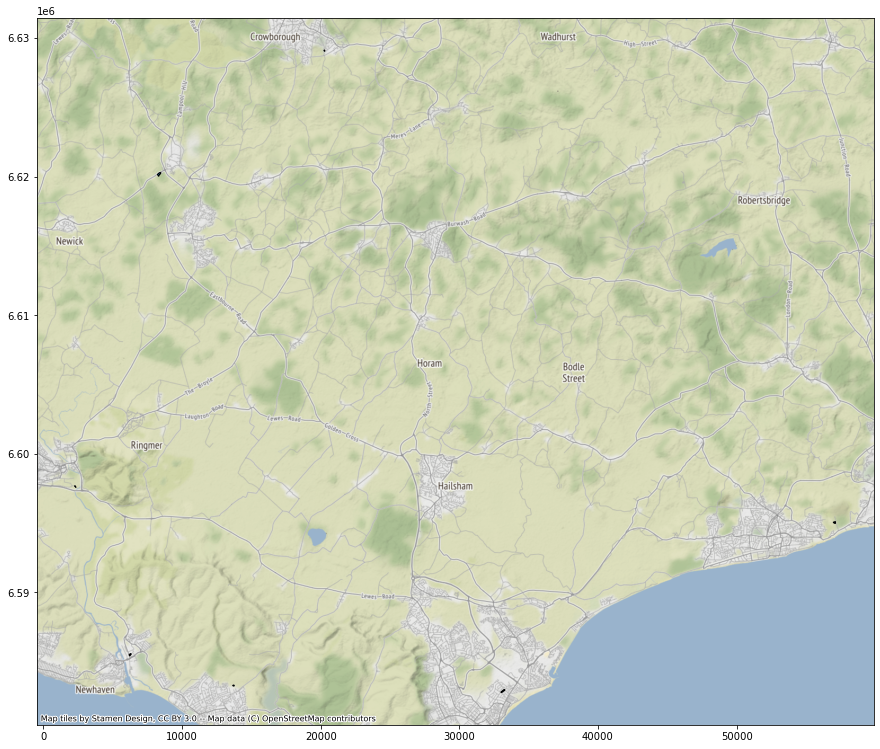

In [11]:
df_wm = gdf.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(15, 15), alpha=1, edgecolor='k')
cx.add_basemap(ax)